# Krypton Lifetime

## Produce lifetime map 

### Author: JJGC

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Mon Aug 27 15:36:17 2018


### Input files

In [3]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6206_0000_9999.h5','dst_6206_10000_19999.h5',
                    'dst_6206_20000_29999.h5','dst_6206_30000_39299.h5']
output_file_name  = ' '
map_file_name     = 'kr_maps_6206.h5'
map_file_name_ts  = 'kr_maps_ts_6206.h5'
emap_file_name    = 'kr_emap_6206.h5'



krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [5]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units

In [9]:
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts

In [10]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.core_functions          import phirad_to_deg

In [11]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import kr_event_selection
from krcal.core.analysis_functions      import kr_event

In [12]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import fit_map

In [13]:
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [14]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName
from krcal.core          import fit_functions_ic as fitf

In [15]:
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps

In [16]:
import krcal.dev.corrections       as corrections 


In [17]:
from numpy import pi

In [18]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [19]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [20]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [21]:
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_9999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_10000_19999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_20000_29999.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_30000_39299.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_6206.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_ts_6206.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_6206.h5')

In [22]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [23]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 4085430


In [24]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Time differences in seconds

In [25]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

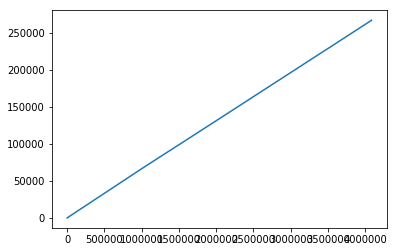

In [26]:
plt.plot(DT)

### Ranges and binning

In [27]:
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-220,  220)
z_range   = (10,  550)
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 12,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [28]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

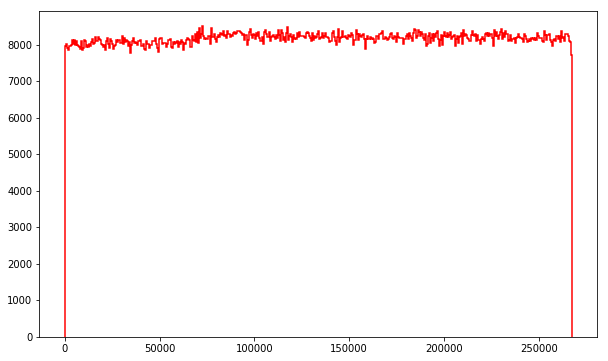

In [29]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

## Divide chamber in sector of R and Phi

In [55]:
R, PHI = rphi_sector_map(nSectors=10, rmax=180, sphi=15)
#print(f'sectors on R   = {R}')
#print(f'sectors on PHI = {PHI}')

In [56]:
W = define_rphi_sectors(R, PHI, verbose=False)

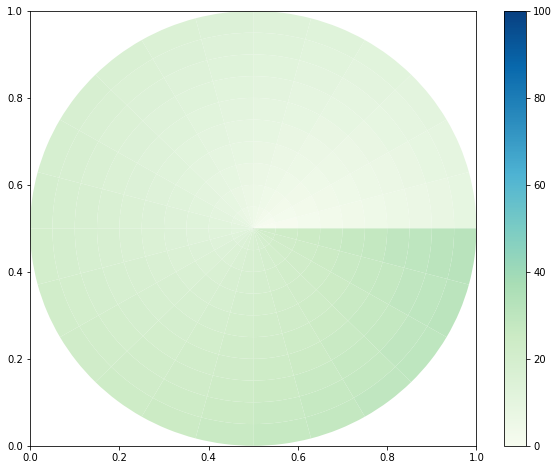

In [57]:
draw_wedges(W, cmap = matplotlib.cm.GnBu, rmax = 180, 
            scale= 0.5, figsize=(10,8), alpha=1.0,
            cr =range(10))

In [58]:
t0 = time.time()
KRES = select_rphi_sectors(dst, DT, E, Q, W, verbose = False)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 KRES: t = 18.85610008239746


### Time 

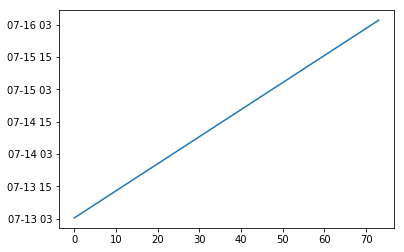

In [59]:
plt.plot(krTimes.timeStamps)

### Event distribution

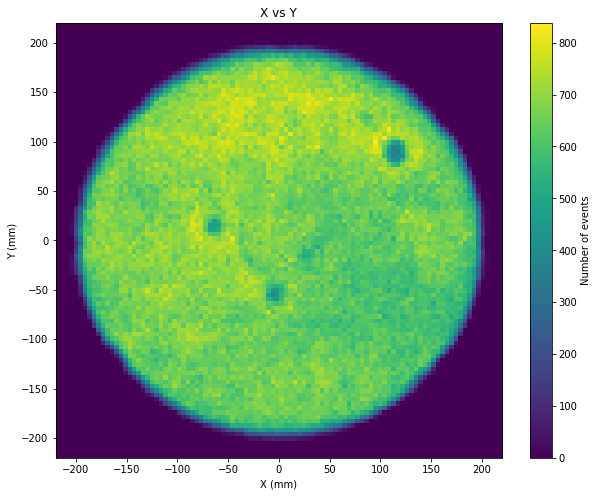

In [60]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

### Events per sector

number of events in sector = 172196.0


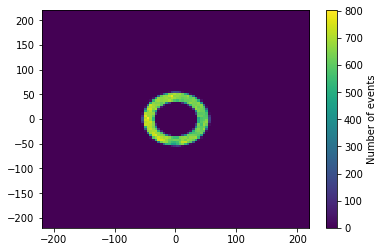

In [61]:
plot_sector(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y, sector=2)

number of events in sector = 35442.0
number of events in sector = 103164.0
number of events in sector = 172196.0
number of events in sector = 241137.0
number of events in sector = 314001.0
number of events in sector = 383883.0
number of events in sector = 459039.0
number of events in sector = 531983.0
number of events in sector = 599579.0
number of events in sector = 660325.0


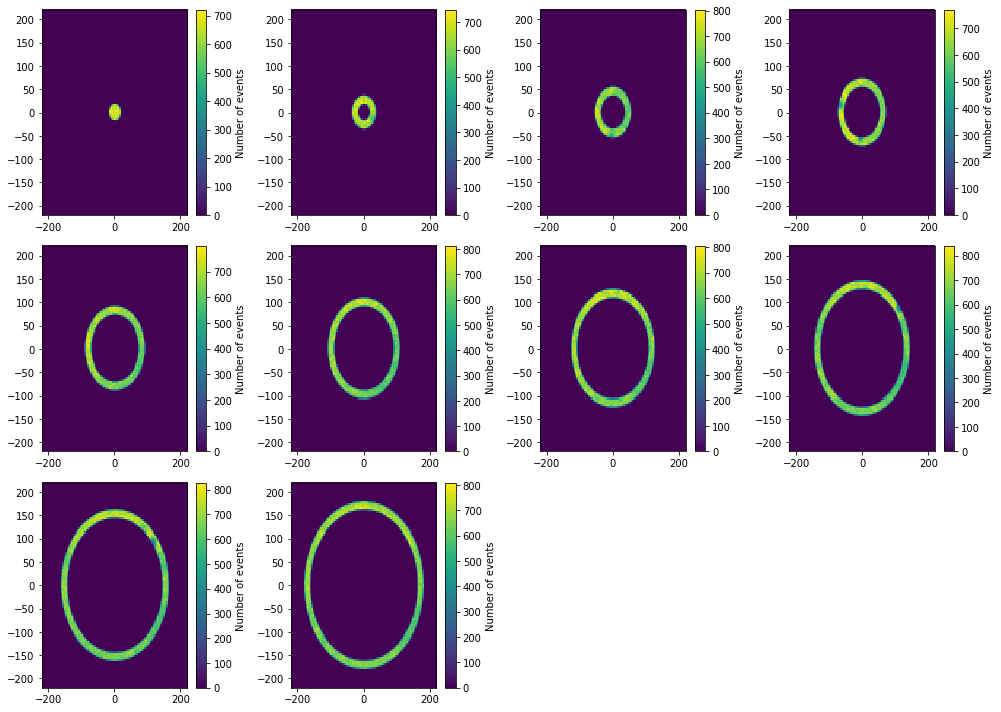

In [62]:
plot_sectors(KRES, krNbins.X, krNbins.Y, krRanges.X,krRanges.Y, nx = 3, ny = 4,figsize=(14,10))

## Fits in radial sectors

### Lifetime is fitted each XT seconds in the radial sectors (0 to 9) defined.

In [90]:
DT[-1] /30000

8.914790266664824

In [91]:
XT = 30000

In [92]:
fps = fit_fcs_in_sectors(0, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)
                    

wedge = 0: chi2 =     1.01 ; e0 = 11899.28 +-  43.92; lt =  2558.86 +- 107.21;
wedge = 1: chi2 =     0.87 ; e0 = 11908.87 +-  32.34; lt =  2595.76 +-  77.75;
wedge = 2: chi2 =     0.94 ; e0 = 11924.17 +-  30.62; lt =  2558.75 +-  63.89;
wedge = 3: chi2 =     0.92 ; e0 = 11924.66 +-  47.37; lt =  2582.20 +-  89.88;
wedge = 4: chi2 =     0.97 ; e0 = 11901.82 +-  36.37; lt =  2562.43 +- 116.40;
wedge = 5: chi2 =     0.97 ; e0 = 11904.48 +-  27.34; lt =  2575.08 +-  75.65;
wedge = 6: chi2 =     1.09 ; e0 = 11868.76 +-  17.44; lt =  2612.99 +-  91.42;
wedge = 7: chi2 =     1.01 ; e0 = 11849.23 +-  43.35; lt =  2634.05 +- 112.10;
wedge = 8: chi2 =     0.95 ; e0 = 11843.77 +-  40.67; lt =  2591.65 +- 100.12;
wedge = 9: chi2 =     0.89 ; e0 = 11795.41 +-  43.86; lt =  2671.19 +- 117.56;
wedge = 10: chi2 =     1.06 ; e0 = 11772.86 +-  38.00; lt =  2653.13 +- 112.40;
wedge = 11: chi2 =     0.99 ; e0 = 11772.59 +-  38.57; lt =  2639.30 +-  93.48;
wedge = 12: chi2 =     1.02 ; e0 = 11750.77 +-  38

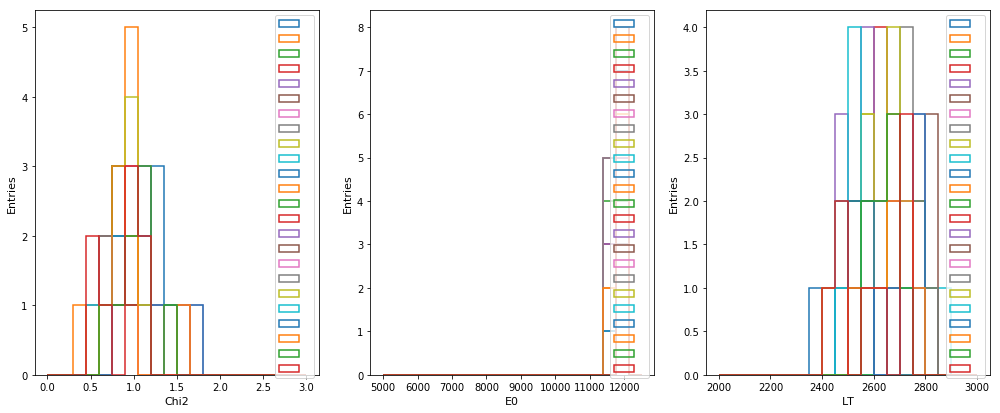

In [93]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

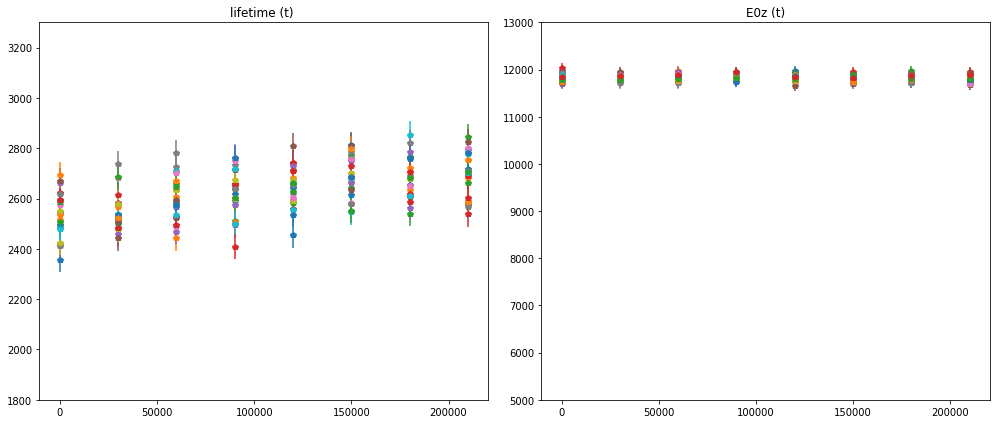

In [94]:
plot_fit_sectors(fps,  range_e0 =(5000,13000), range_lt=(1800, 3300))

In [95]:
fps = fit_fcs_in_sectors(1, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)
 

wedge = 0: chi2 =     0.92 ; e0 = 11793.64 +-  25.55; lt =  2573.11 +-  83.81;
wedge = 1: chi2 =     0.77 ; e0 = 11760.97 +-  15.22; lt =  2602.84 +-  65.22;
wedge = 2: chi2 =     0.84 ; e0 = 11767.12 +-  19.55; lt =  2644.13 +-  62.92;
wedge = 3: chi2 =     0.96 ; e0 = 11864.07 +-  27.25; lt =  2613.40 +-  40.48;
wedge = 4: chi2 =     0.92 ; e0 = 11900.65 +-  14.54; lt =  2582.23 +-  61.91;
wedge = 5: chi2 =     0.89 ; e0 = 11859.97 +-  19.45; lt =  2596.80 +-  57.50;
wedge = 6: chi2 =     0.94 ; e0 = 11844.62 +-  18.73; lt =  2585.15 +-  49.58;
wedge = 7: chi2 =     0.98 ; e0 = 11849.63 +-  23.69; lt =  2571.22 +-  69.33;
wedge = 8: chi2 =     0.93 ; e0 = 11800.53 +-  20.95; lt =  2575.53 +-  71.26;
wedge = 9: chi2 =     0.98 ; e0 = 11690.40 +-  22.21; lt =  2639.13 +-  89.82;
wedge = 10: chi2 =     0.91 ; e0 = 11621.19 +-  20.49; lt =  2690.03 +-  68.42;
wedge = 11: chi2 =     0.94 ; e0 = 11581.77 +-  27.08; lt =  2706.38 +-  78.33;
wedge = 12: chi2 =     0.84 ; e0 = 11614.39 +-  12

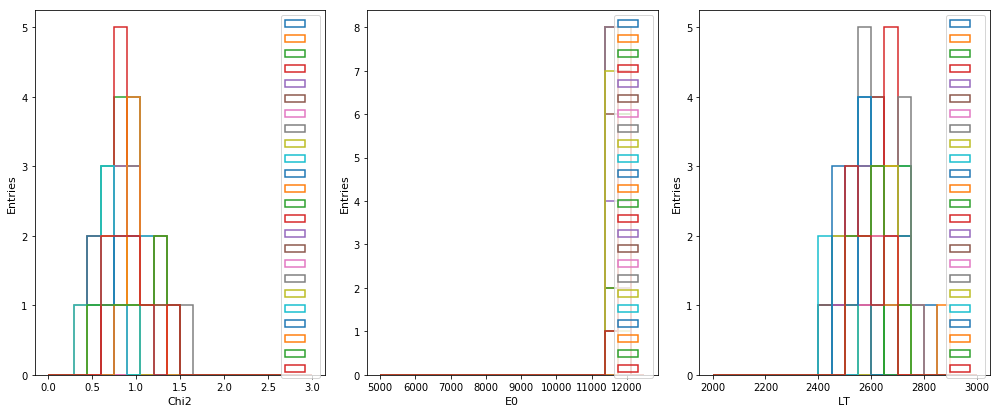

In [96]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts )

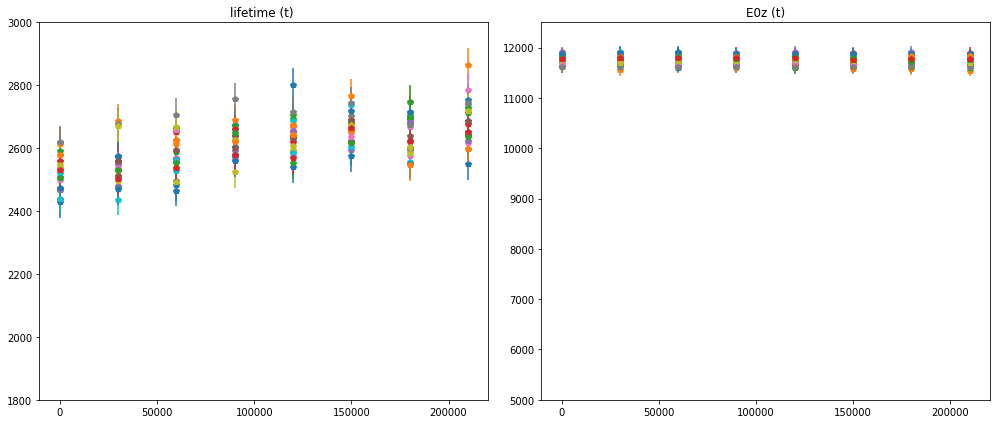

In [97]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [98]:
fps = fit_fcs_in_sectors(2, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)



wedge = 0: chi2 =     0.95 ; e0 = 11773.69 +-  24.00; lt =  2585.94 +-  52.38;
wedge = 1: chi2 =     1.00 ; e0 = 11794.43 +-  11.70; lt =  2621.41 +-  48.81;
wedge = 2: chi2 =     0.86 ; e0 = 12015.30 +-  19.73; lt =  2532.23 +-  59.75;
wedge = 3: chi2 =     0.89 ; e0 = 12209.68 +-  17.24; lt =  2456.29 +-  48.69;
wedge = 4: chi2 =     0.87 ; e0 = 12079.89 +-  14.54; lt =  2477.66 +-  48.14;
wedge = 5: chi2 =     0.93 ; e0 = 11833.78 +-  11.59; lt =  2582.17 +-  46.56;
wedge = 6: chi2 =     0.92 ; e0 = 11794.87 +-  13.17; lt =  2542.15 +-  66.55;
wedge = 7: chi2 =     0.80 ; e0 = 11796.08 +-  11.86; lt =  2515.98 +-  49.16;
wedge = 8: chi2 =     1.12 ; e0 = 11644.47 +-  19.59; lt =  2594.82 +-  80.88;
wedge = 9: chi2 =     0.78 ; e0 = 11613.12 +-  12.92; lt =  2613.28 +-  59.29;
wedge = 10: chi2 =     0.87 ; e0 = 11694.69 +-   8.04; lt =  2554.59 +-  53.67;
wedge = 11: chi2 =     0.98 ; e0 = 11573.98 +-  16.23; lt =  2631.15 +-  63.95;
wedge = 12: chi2 =     0.95 ; e0 = 11402.90 +-  14

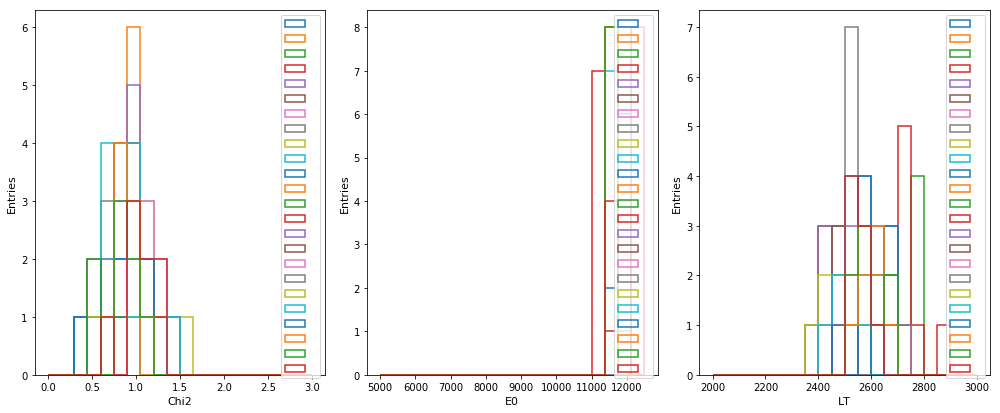

In [99]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

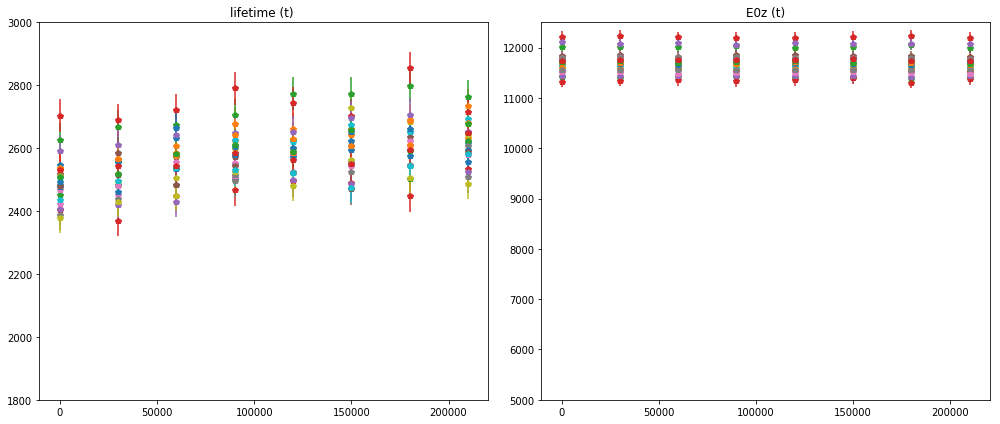

In [100]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [101]:
fps = fit_fcs_in_sectors(3, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.84 ; e0 = 11939.21 +-   9.97; lt =  2486.92 +-  28.81;
wedge = 1: chi2 =     0.80 ; e0 = 12033.97 +-  10.65; lt =  2524.35 +-  54.92;
wedge = 2: chi2 =     0.93 ; e0 = 12204.82 +-  12.22; lt =  2487.54 +-  48.81;
wedge = 3: chi2 =     0.86 ; e0 = 12225.86 +-  16.29; lt =  2463.75 +-  41.37;
wedge = 4: chi2 =     0.81 ; e0 = 12001.69 +-  17.24; lt =  2484.58 +-  50.16;
wedge = 5: chi2 =     0.99 ; e0 = 11705.62 +-   7.49; lt =  2533.57 +-  42.13;
wedge = 6: chi2 =     0.83 ; e0 = 11612.38 +-  17.08; lt =  2531.28 +-  46.23;
wedge = 7: chi2 =     0.96 ; e0 = 11625.02 +-   9.49; lt =  2508.15 +-  43.87;
wedge = 8: chi2 =     1.02 ; e0 = 11571.12 +-  18.08; lt =  2523.72 +-  45.33;
wedge = 9: chi2 =     0.91 ; e0 = 11516.70 +-  13.90; lt =  2549.67 +-  57.05;
wedge = 10: chi2 =     0.75 ; e0 = 11514.20 +-  16.87; lt =  2578.59 +-  70.10;
wedge = 11: chi2 =     0.89 ; e0 = 11418.01 +-  15.95; lt =  2619.73 +-  69.06;
wedge = 12: chi2 =     0.87 ; e0 = 11278.32 +-  15

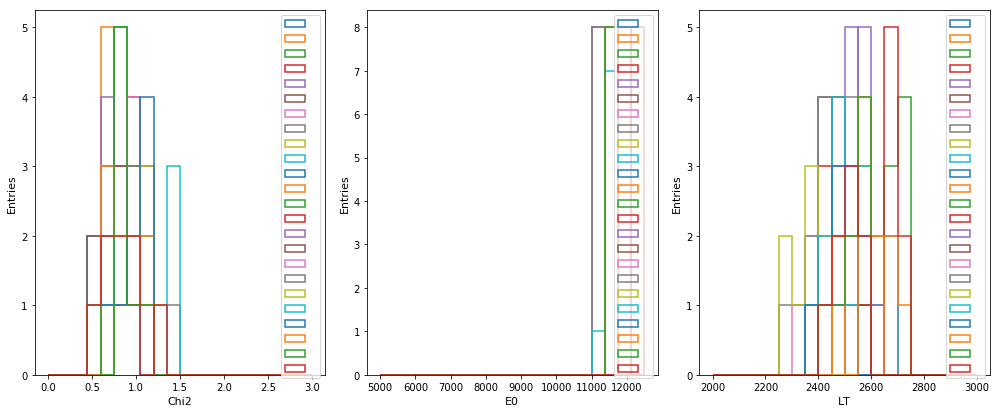

In [102]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

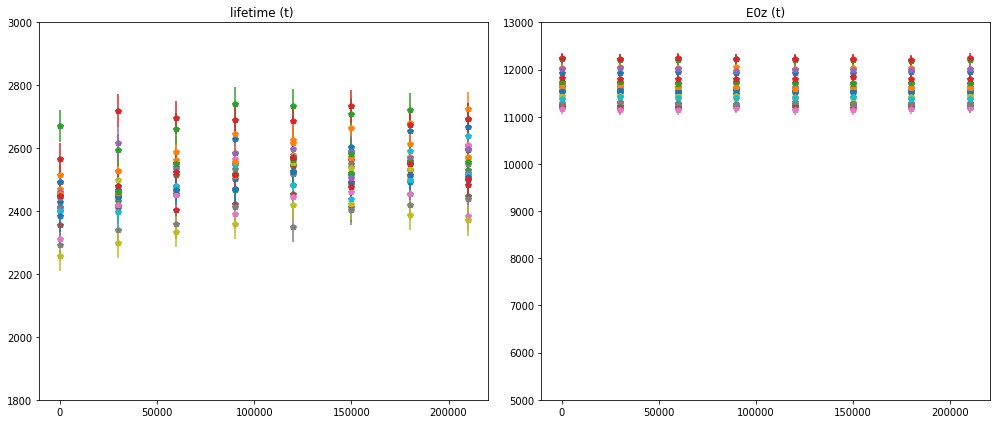

In [103]:
plot_fit_sectors(fps,  range_e0 =(5000,13000), range_lt=(1800, 3000))

In [104]:
fps = fit_fcs_in_sectors(4, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.86 ; e0 = 11818.13 +-  10.73; lt =  2501.92 +-  32.81;
wedge = 1: chi2 =     0.85 ; e0 = 11942.83 +-  10.22; lt =  2505.46 +-  33.75;
wedge = 2: chi2 =     0.92 ; e0 = 11975.14 +-   9.73; lt =  2500.70 +-  38.72;
wedge = 3: chi2 =     0.94 ; e0 = 11867.07 +-  17.41; lt =  2510.07 +-  41.39;
wedge = 4: chi2 =     0.96 ; e0 = 11705.28 +-  11.79; lt =  2520.20 +-  44.32;
wedge = 5: chi2 =     0.87 ; e0 = 11588.90 +-  13.65; lt =  2515.67 +-  30.19;
wedge = 6: chi2 =     0.97 ; e0 = 11421.40 +-  13.20; lt =  2529.83 +-  37.28;
wedge = 7: chi2 =     0.95 ; e0 = 11487.92 +-   6.01; lt =  2480.52 +-  40.95;
wedge = 8: chi2 =     1.02 ; e0 = 11403.38 +-  12.30; lt =  2472.11 +-  28.23;
wedge = 9: chi2 =     0.85 ; e0 = 11250.45 +-  16.69; lt =  2530.20 +-  54.63;
wedge = 10: chi2 =     0.89 ; e0 = 11154.59 +-  17.08; lt =  2593.51 +-  74.30;
wedge = 11: chi2 =     0.90 ; e0 = 11107.72 +-   8.82; lt =  2675.18 +-  58.36;
wedge = 12: chi2 =     0.86 ; e0 = 11054.74 +-  12

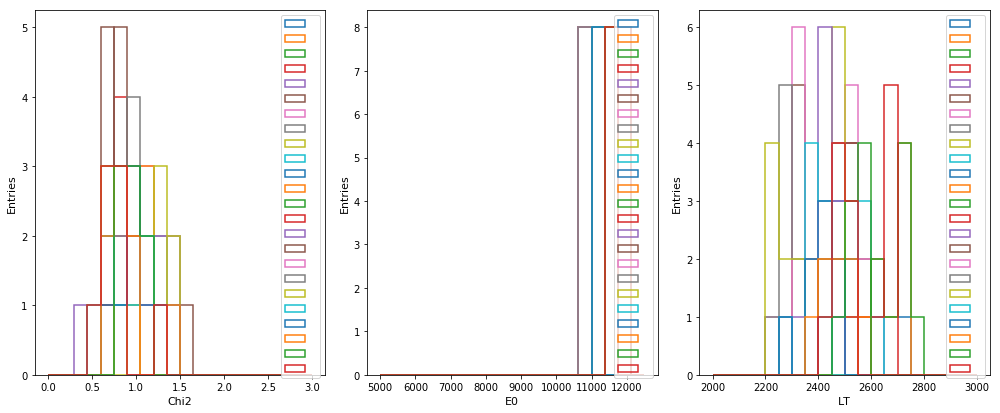

In [105]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

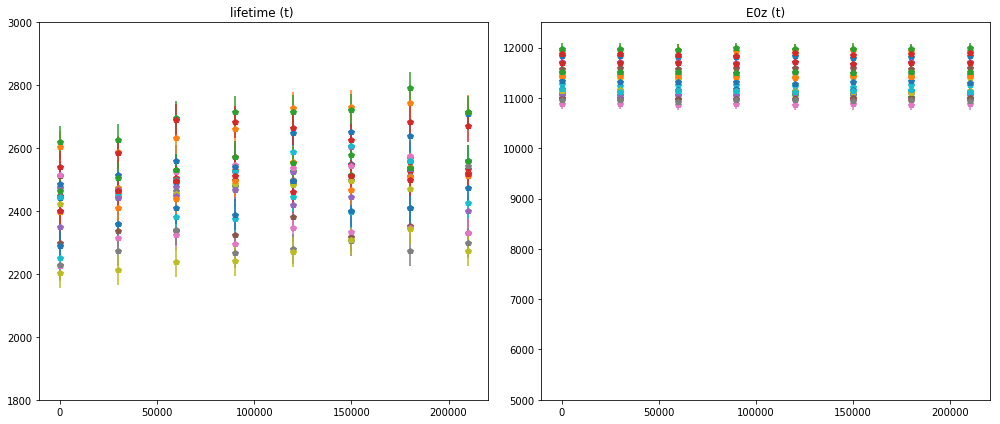

In [106]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [107]:
fps = fit_fcs_in_sectors(5, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.86 ; e0 = 11538.35 +-  10.29; lt =  2532.37 +-  36.01;
wedge = 1: chi2 =     0.92 ; e0 = 11727.24 +-   8.68; lt =  2517.17 +-  27.06;
wedge = 2: chi2 =     1.00 ; e0 = 11642.78 +-  10.25; lt =  2532.90 +-  26.27;
wedge = 3: chi2 =     0.94 ; e0 = 11564.09 +-  11.34; lt =  2536.78 +-  40.72;
wedge = 4: chi2 =     0.86 ; e0 = 11597.01 +-   8.16; lt =  2471.66 +-  42.13;
wedge = 5: chi2 =     1.11 ; e0 = 11632.25 +-  13.62; lt =  2412.67 +-  32.90;
wedge = 6: chi2 =     0.91 ; e0 = 11364.38 +-   6.47; lt =  2441.69 +-  28.08;
wedge = 7: chi2 =     0.80 ; e0 = 11359.79 +-  17.91; lt =  2424.24 +-  51.02;
wedge = 8: chi2 =     1.07 ; e0 = 11071.03 +-  13.84; lt =  2510.59 +-  52.69;
wedge = 9: chi2 =     0.84 ; e0 = 10962.99 +-  12.62; lt =  2516.83 +-  54.86;
wedge = 10: chi2 =     1.21 ; e0 = 10831.65 +-  12.82; lt =  2593.34 +-  65.29;
wedge = 11: chi2 =     0.82 ; e0 = 10921.81 +-  14.13; lt =  2628.49 +-  76.74;
wedge = 12: chi2 =     0.95 ; e0 = 10794.00 +-  11

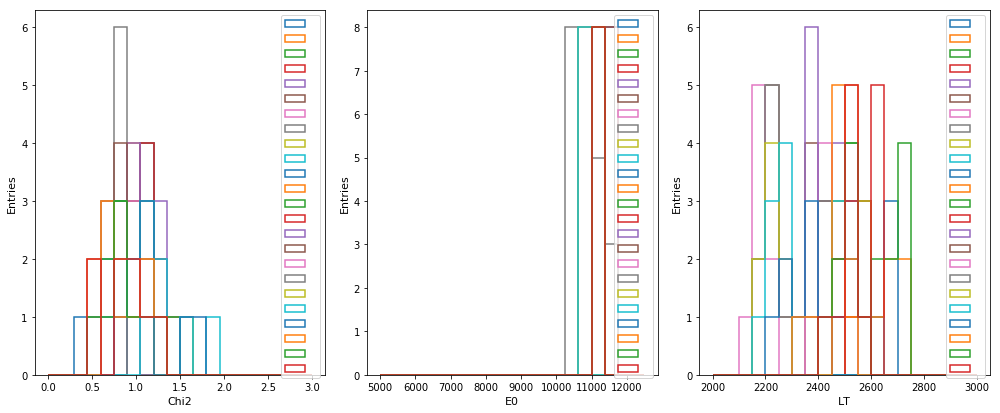

In [108]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

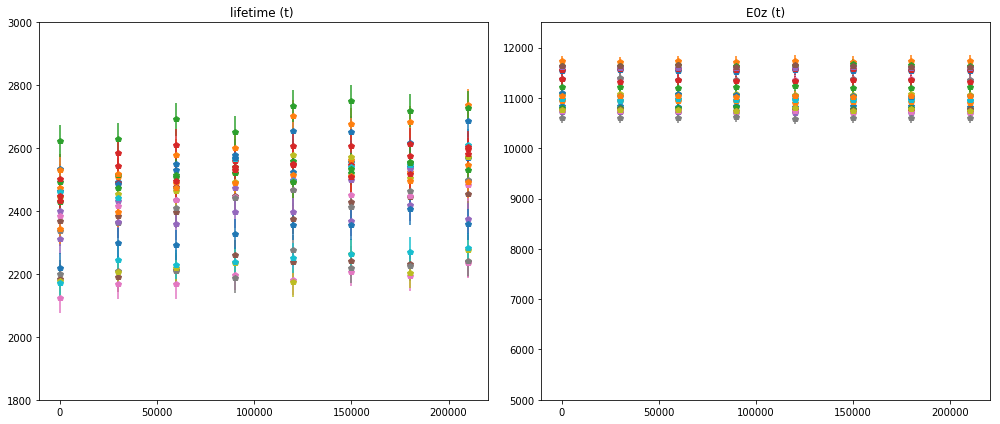

In [109]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [110]:
fps = fit_fcs_in_sectors(6, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (7000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.84 ; e0 = 11305.48 +-  10.18; lt =  2514.99 +-  32.04;
wedge = 1: chi2 =     0.68 ; e0 = 11586.21 +-   9.59; lt =  2488.18 +-  35.61;
wedge = 2: chi2 =     0.94 ; e0 = 11463.68 +-  10.30; lt =  2520.02 +-  32.12;
wedge = 3: chi2 =     1.02 ; e0 = 11494.41 +-   6.64; lt =  2468.19 +-  21.56;
wedge = 4: chi2 =     1.01 ; e0 = 11416.58 +-  10.36; lt =  2459.52 +-  23.60;
wedge = 5: chi2 =     0.98 ; e0 = 11462.91 +-  11.72; lt =  2385.71 +-  21.38;
wedge = 6: chi2 =     1.10 ; e0 = 11195.86 +-   9.69; lt =  2408.89 +-  26.06;
wedge = 7: chi2 =     1.13 ; e0 = 11137.34 +-  10.06; lt =  2382.37 +-  23.84;
wedge = 8: chi2 =     0.84 ; e0 = 10831.60 +-   9.91; lt =  2456.63 +-  36.05;
wedge = 9: chi2 =     0.85 ; e0 = 10731.31 +-   9.67; lt =  2459.10 +-  40.86;
wedge = 10: chi2 =     1.04 ; e0 = 10573.91 +-  14.91; lt =  2546.16 +-  65.82;
wedge = 11: chi2 =     1.03 ; e0 = 10648.98 +-  14.02; lt =  2627.53 +-  71.03;
wedge = 12: chi2 =     0.92 ; e0 = 10462.89 +-   8

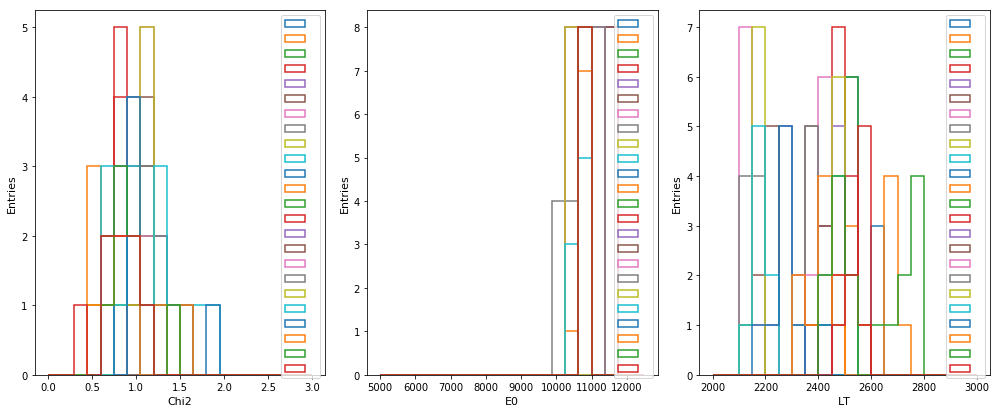

In [111]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(2000, 3000))
print_fit_sectors_pars(fpts)

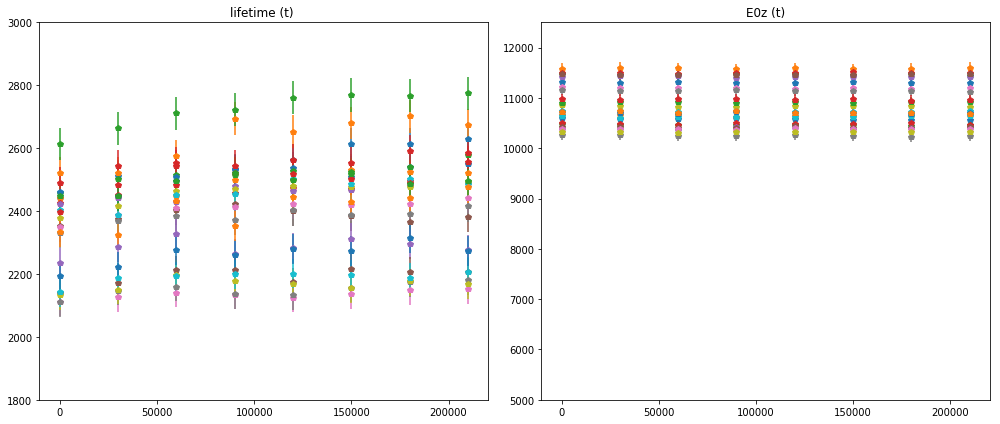

In [112]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [113]:
fps = fit_fcs_in_sectors(7, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.82 ; e0 = 10990.35 +-  12.65; lt =  2520.34 +-  48.07;
wedge = 1: chi2 =     0.94 ; e0 = 11301.42 +-   8.10; lt =  2479.89 +-  31.57;
wedge = 2: chi2 =     0.88 ; e0 = 11280.65 +-  10.24; lt =  2484.30 +-  21.78;
wedge = 3: chi2 =     1.11 ; e0 = 11312.02 +-   9.08; lt =  2417.94 +-  26.29;
wedge = 4: chi2 =     1.09 ; e0 = 11205.08 +-   6.82; lt =  2370.17 +-  19.04;
wedge = 5: chi2 =     1.11 ; e0 = 11166.45 +-   8.85; lt =  2344.10 +-  20.09;
wedge = 6: chi2 =     1.02 ; e0 = 10912.39 +-  10.07; lt =  2343.40 +-  24.30;
wedge = 7: chi2 =     0.95 ; e0 = 10774.79 +-   9.38; lt =  2345.35 +-  10.55;
wedge = 8: chi2 =     0.99 ; e0 = 10480.98 +-  13.02; lt =  2399.38 +-  36.12;
wedge = 9: chi2 =     0.88 ; e0 = 10367.21 +-  10.56; lt =  2428.79 +-  33.08;
wedge = 10: chi2 =     1.18 ; e0 = 10239.78 +-   8.92; lt =  2521.14 +-  53.15;
wedge = 11: chi2 =     0.82 ; e0 = 10304.70 +-  13.66; lt =  2606.94 +-  65.89;
wedge = 12: chi2 =     0.88 ; e0 = 10169.81 +-   8

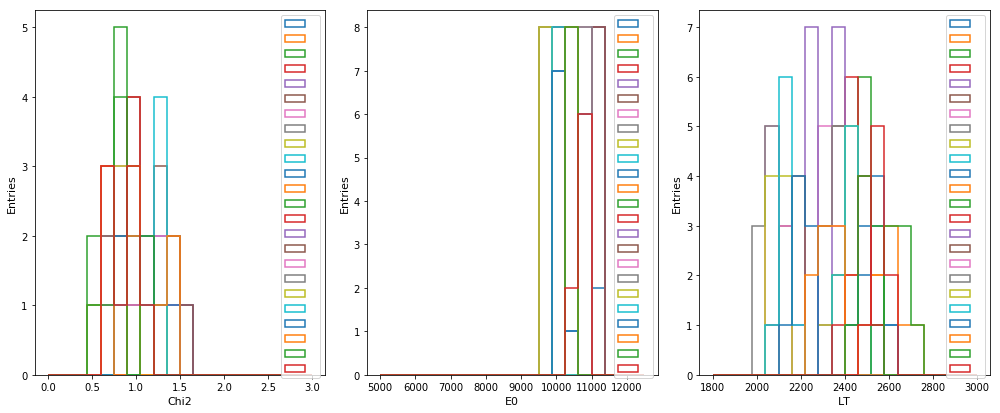

In [114]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1800, 3000))
print_fit_sectors_pars(fpts)

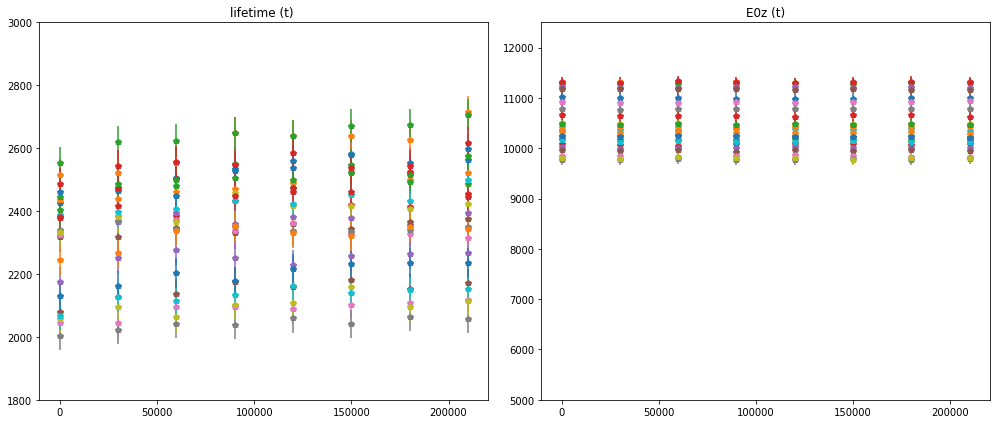

In [115]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [116]:
fps = fit_fcs_in_sectors(8, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.92 ; e0 = 10591.27 +-   9.98; lt =  2509.77 +-  47.19;
wedge = 1: chi2 =     0.84 ; e0 = 10845.35 +-  13.14; lt =  2468.96 +-  34.24;
wedge = 2: chi2 =     1.05 ; e0 = 10962.71 +-  11.83; lt =  2436.74 +-  30.91;
wedge = 3: chi2 =     1.00 ; e0 = 10875.74 +-  11.37; lt =  2399.98 +-  32.78;
wedge = 4: chi2 =     0.90 ; e0 = 10788.98 +-  11.98; lt =  2336.63 +-  19.51;
wedge = 5: chi2 =     0.91 ; e0 = 10686.62 +-   9.83; lt =  2345.00 +-  16.66;
wedge = 6: chi2 =     1.00 ; e0 = 10407.26 +-  13.96; lt =  2301.53 +-  26.07;
wedge = 7: chi2 =     0.89 ; e0 = 10247.98 +-   6.46; lt =  2299.72 +-  16.60;
wedge = 8: chi2 =     0.91 ; e0 =  9973.09 +-  13.09; lt =  2365.48 +-  30.33;
wedge = 9: chi2 =     1.17 ; e0 =  9842.66 +-   9.92; lt =  2398.07 +-  32.60;
wedge = 10: chi2 =     0.96 ; e0 =  9827.69 +-  14.55; lt =  2451.10 +-  50.34;
wedge = 11: chi2 =     0.93 ; e0 =  9839.66 +-  10.78; lt =  2562.26 +-  72.56;
wedge = 12: chi2 =     0.91 ; e0 =  9685.67 +-  13

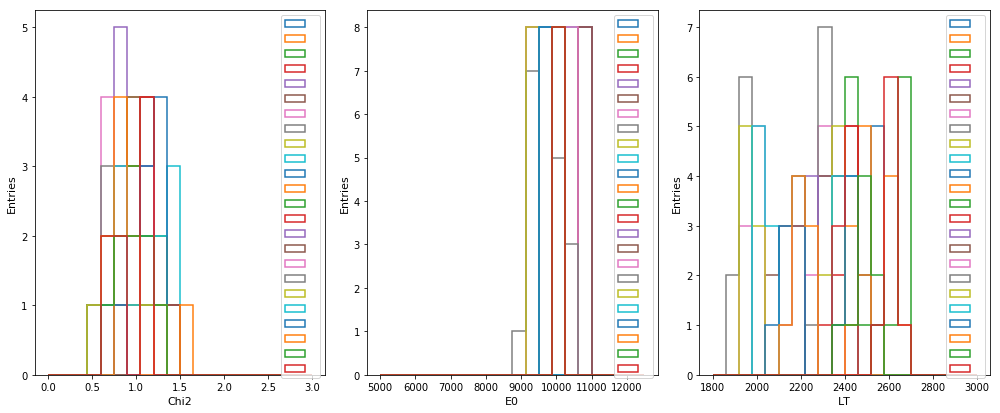

In [117]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1800, 3000))
print_fit_sectors_pars(fpts)

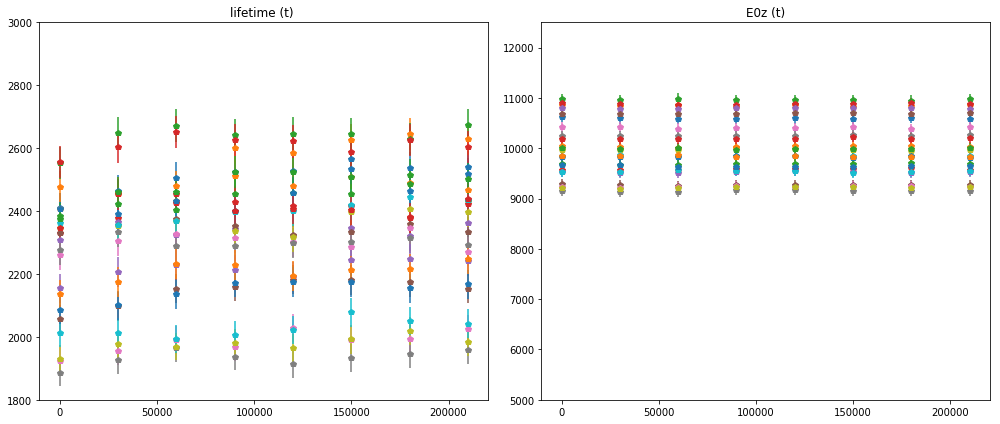

In [118]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1800, 3000))

In [119]:
fps = fit_fcs_in_sectors(9, XT, DT, KRES, krNbins.Z, krNbins.S2e,
                         range_z=(50,550), 
                         range_e = (5000, 12000),
                         energy = 'S2e', fit = FitType.profile)

wedge = 0: chi2 =     0.80 ; e0 = 10055.23 +-  12.66; lt =  2466.72 +-  46.12;
wedge = 1: chi2 =     0.80 ; e0 = 10156.52 +-  13.22; lt =  2451.03 +-  38.88;
wedge = 2: chi2 =     0.95 ; e0 = 10338.30 +-  11.36; lt =  2363.12 +-  37.44;
wedge = 3: chi2 =     1.14 ; e0 = 10330.83 +-  17.37; lt =  2286.08 +-  28.49;
wedge = 4: chi2 =     0.92 ; e0 = 10140.14 +-   9.03; lt =  2315.43 +-  20.99;
wedge = 5: chi2 =     0.90 ; e0 = 10057.61 +-  23.56; lt =  2276.77 +-  41.33;
wedge = 6: chi2 =     0.92 ; e0 =  9711.64 +-  14.87; lt =  2251.98 +-  30.56;
wedge = 7: chi2 =     0.96 ; e0 =  9523.70 +-  15.57; lt =  2277.47 +-  34.61;
wedge = 8: chi2 =     0.96 ; e0 =  9391.74 +-  11.37; lt =  2273.59 +-  28.27;
wedge = 9: chi2 =     0.97 ; e0 =  9206.68 +-  12.79; lt =  2339.39 +-  34.82;
wedge = 10: chi2 =     1.02 ; e0 =  9187.46 +-  12.42; lt =  2396.51 +-  51.15;
wedge = 11: chi2 =     0.74 ; e0 =  9143.70 +-  17.91; lt =  2513.64 +-  85.05;
wedge = 12: chi2 =     1.02 ; e0 =  9113.52 +-  14

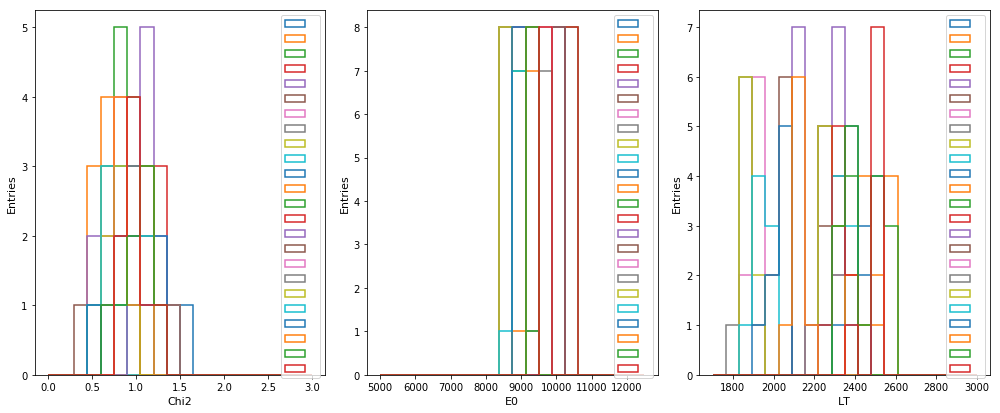

In [120]:
fpts = histo_fit_sectors(fps, range_chi2=(0,3), range_e0 =(5000,12500), range_lt=(1700, 3000))
print_fit_sectors_pars(fpts)

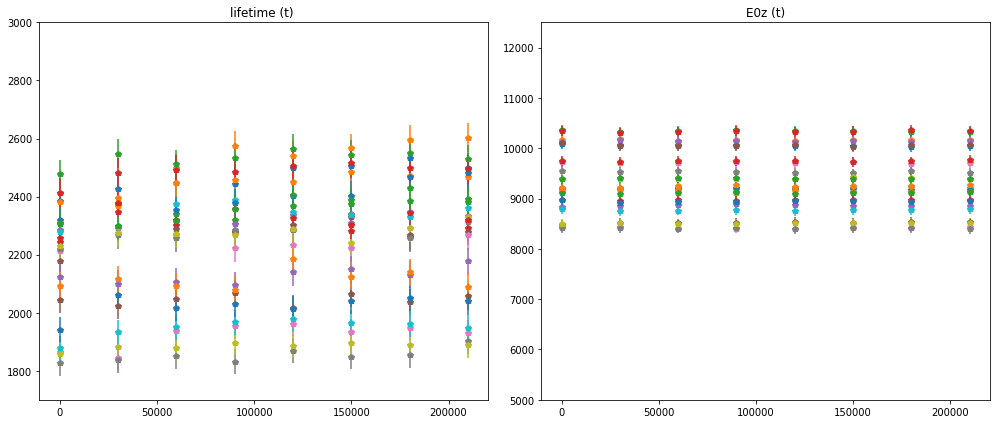

In [121]:
plot_fit_sectors(fps,  range_e0 =(5000,12500), range_lt=(1700, 3000))

### Fits in sectors:
1. chi2 of fits is good.
2. E0 decreases in each sector and varies significantly with phi.
3. LT has an structure, splitting in some sectors in two peaks.

## Maps

#### fit maps. The object returned is a Dict[int, List[FitParTS]] where

```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.arra`
```
Thus, for each radial sector (0, 1, 2...) the function returns a list of objects, one object per phi sector (or wedge). Each object contains 6 time series; ts is time (time difference wrt to the start of the run); e0, lt... are fitted parameters to time slices.

In [122]:
fmap = fit_map(XT, DT, KRES, 
               krNbins.Z, krNbins.S2e,
               range_z     = (50,550),
               range_e     = (5000, 13000),
               range_chi2  = (0,3),
               range_lt    = (1700, 3300),
               energy      = 'S2e', 
               fit         = FitType.profile,
               verbose     = True)

Fitting sector 0
 number of wedges in sector 24
Fitting sector 1
 number of wedges in sector 24
Fitting sector 2
 number of wedges in sector 24
Fitting sector 3
 number of wedges in sector 24
Fitting sector 4
 number of wedges in sector 24
Fitting sector 5
 number of wedges in sector 24
Fitting sector 6
 number of wedges in sector 24
Fitting sector 7
 number of wedges in sector 24
Fitting sector 8
 number of wedges in sector 24
Fitting sector 9
 number of wedges in sector 24


In [143]:
ts = fmap[0][0].ts

In [144]:
ts

array([     0,  30000,  60000,  90000, 120000, 150000, 180000, 210000])

In [133]:
DT

array([0.00000000e+00, 2.16000080e-01, 2.30000019e-01, ...,
       2.67443503e+05, 2.67443696e+05, 2.67443708e+05])

#### Obtain time maps from fmap: The object returned is a SectorMapTS
```
@dataclass
class SectorMapTS:  # Map in chamber sector containing time series of pars
    chi2  : Dict[int, List[np.array]]
    e0    : Dict[int, List[np.array]]
    lt    : Dict[int, List[np.array]]
    e0u   : Dict[int, List[np.array]]
    ltu   : Dict[int, List[np.array]]
```
Here the dictionary is arranged for each of the relevant variables.

In [127]:
tsm = tsmap_from_fmap(fmap, verbose  = False)

<ErrorbarContainer object of 3 artists>

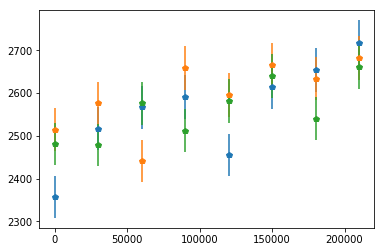

In [128]:
plt.errorbar(ts, tsm.lt[0][0], np.sqrt(tsm.lt[0][0]), fmt="p")
plt.errorbar(ts, tsm.lt[0][1], np.sqrt(tsm.lt[0][1]), fmt="p")
plt.errorbar(ts, tsm.lt[0][2], np.sqrt(tsm.lt[0][2]), fmt="p")

<ErrorbarContainer object of 3 artists>

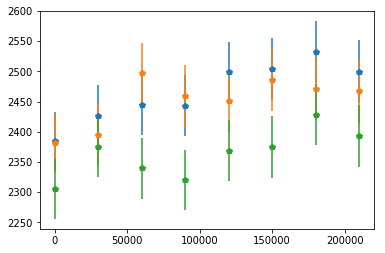

In [129]:
plt.errorbar(ts, tsm.lt[9][0], np.sqrt(tsm.lt[0][0]), fmt="p")
plt.errorbar(ts, tsm.lt[9][1], np.sqrt(tsm.lt[0][1]), fmt="p")
plt.errorbar(ts, tsm.lt[9][2], np.sqrt(tsm.lt[0][2]), fmt="p")

#### Obtain ampa from tsm: The object returned is ASectorMap
```
@dataclass
class ASectorMap:  # Map in chamber sector containing average of pars
    chi2  : Dict[int, List[float]]
    e0    : Dict[int, List[float]]
    lt    : Dict[int, List[float]]
    e0u   : Dict[int, List[float]]
    ltu   : Dict[int, List[float]]
```
In this ASectorMap each wege contains a single number, and thus ASectorMap is really a 
collection of 5 maps. 

#### The map that averages the time series is obtained by setting ts = -1 

In [136]:
am = amap_from_tsmap(tsm, 
                     ts = -1, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))

In [137]:
asm = relative_errors(am)

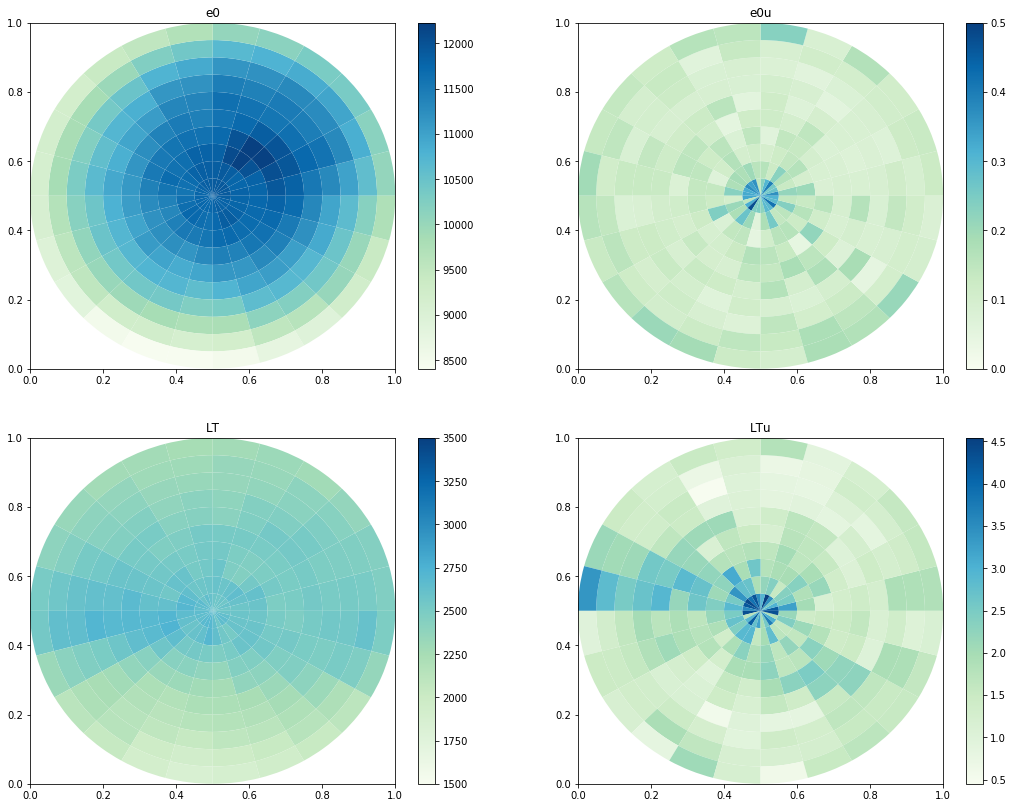

In [138]:
draw_maps(W, asm,  
          e0lims  = None,
          ltlims  = (1500, 3500),
          eulims  = (0, 0.5),
          lulims  = None,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

#### The maps can be saved to file

In [224]:
write_maps(asm, filename=fn.map_file_name)

#### And retrieved from file

In [234]:
me0df, me0udf, mltdf, mltudf = read_maps(filename=fn.map_file_name)

#### To produce a map for a given point in the same series one uses ts = 0, 1... len(ts)

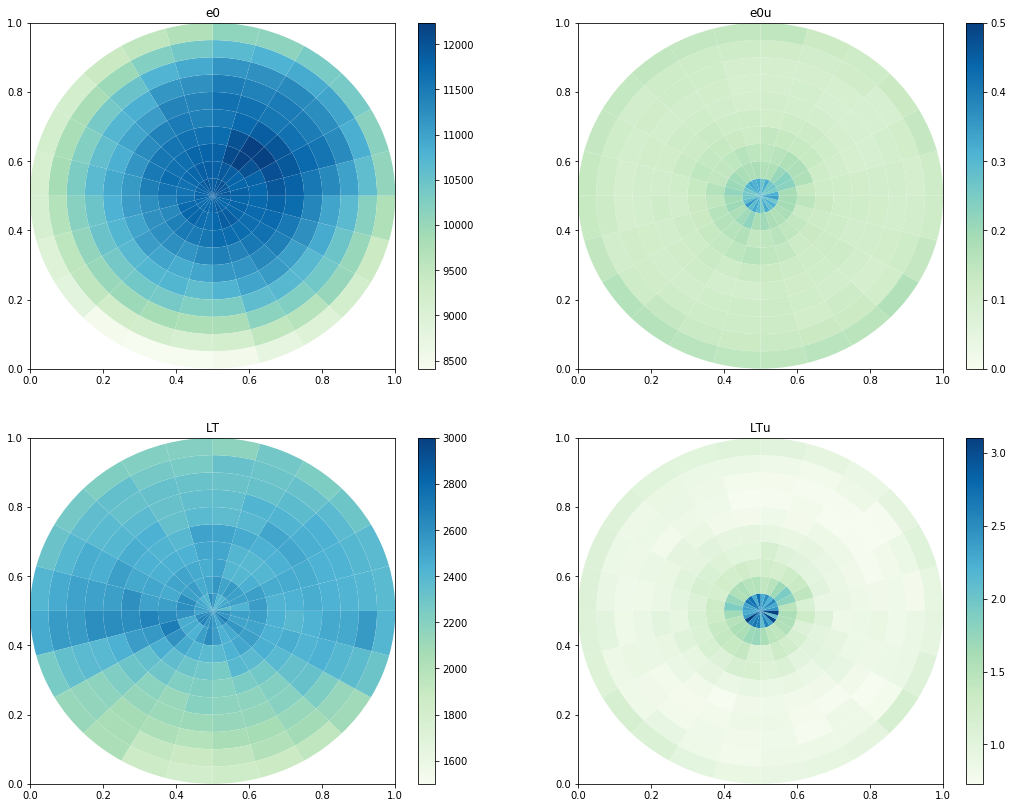

In [139]:
am = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))
asm = relative_errors(am)
draw_maps(W, asm,  
          e0lims  = None,
          ltlims  = (1500, 3000),
          eulims  = (0, 0.5),
          lulims  = None,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

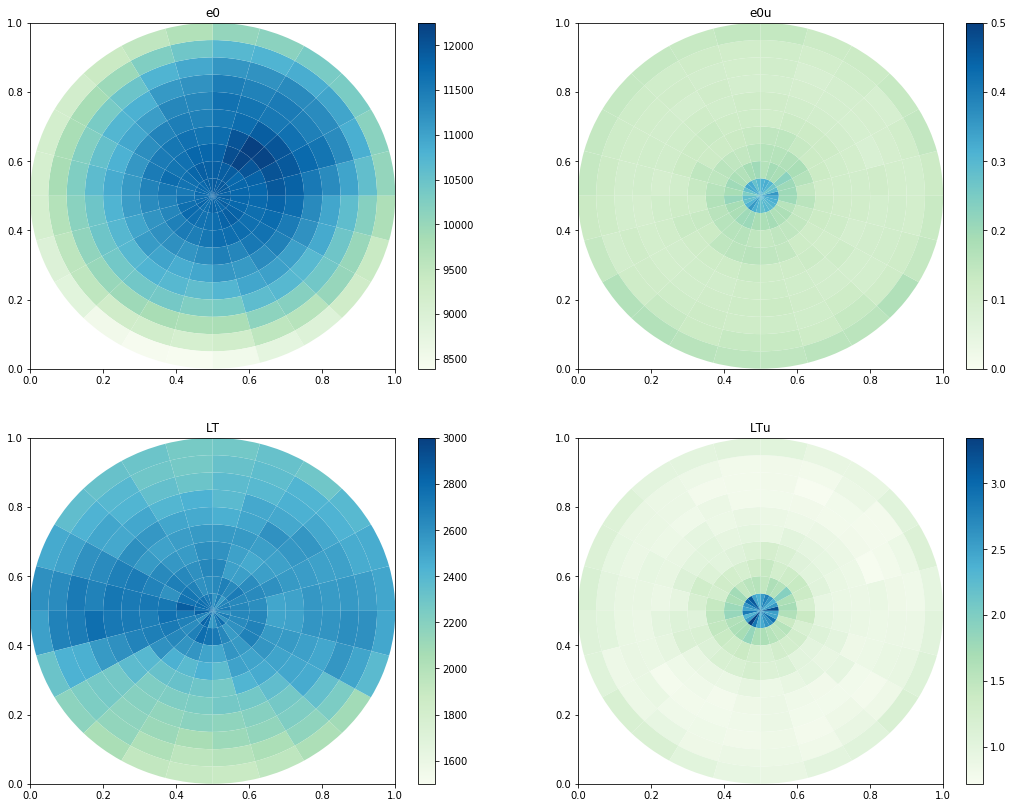

In [141]:
am = amap_from_tsmap(tsm, 
                     ts = len(ts) -1, 
                     range_e     = (5000, 13000),
                     range_chi2  = (0,3),
                     range_lt    = (1800, 3000))
asm = relative_errors(am)
draw_maps(W, asm,  
          e0lims  = None,
          ltlims  = (1500, 3000),
          eulims  = (0, 0.5),
          lulims  = None,
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(18,14))

#### Full map series:

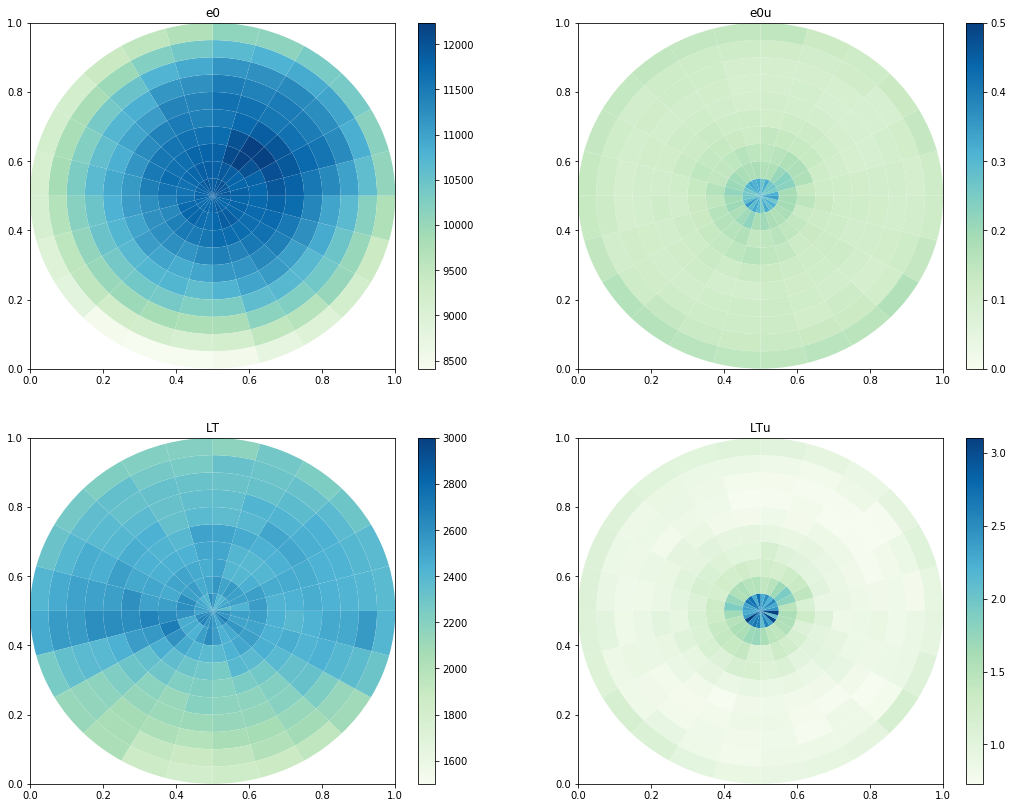

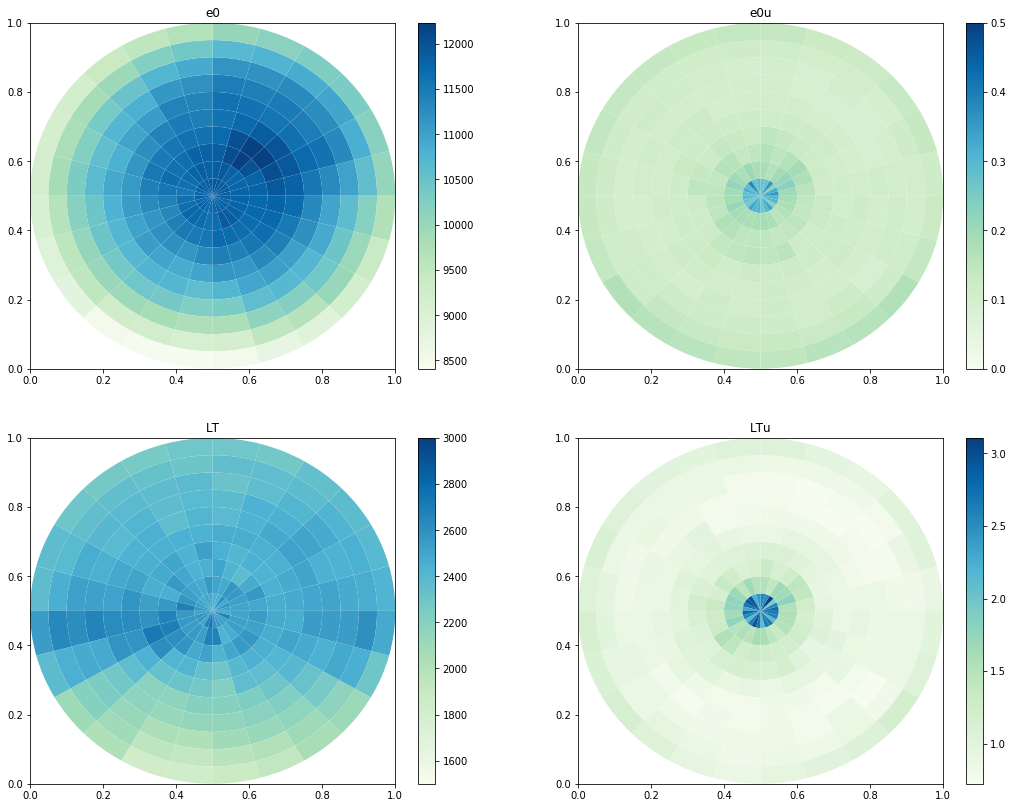

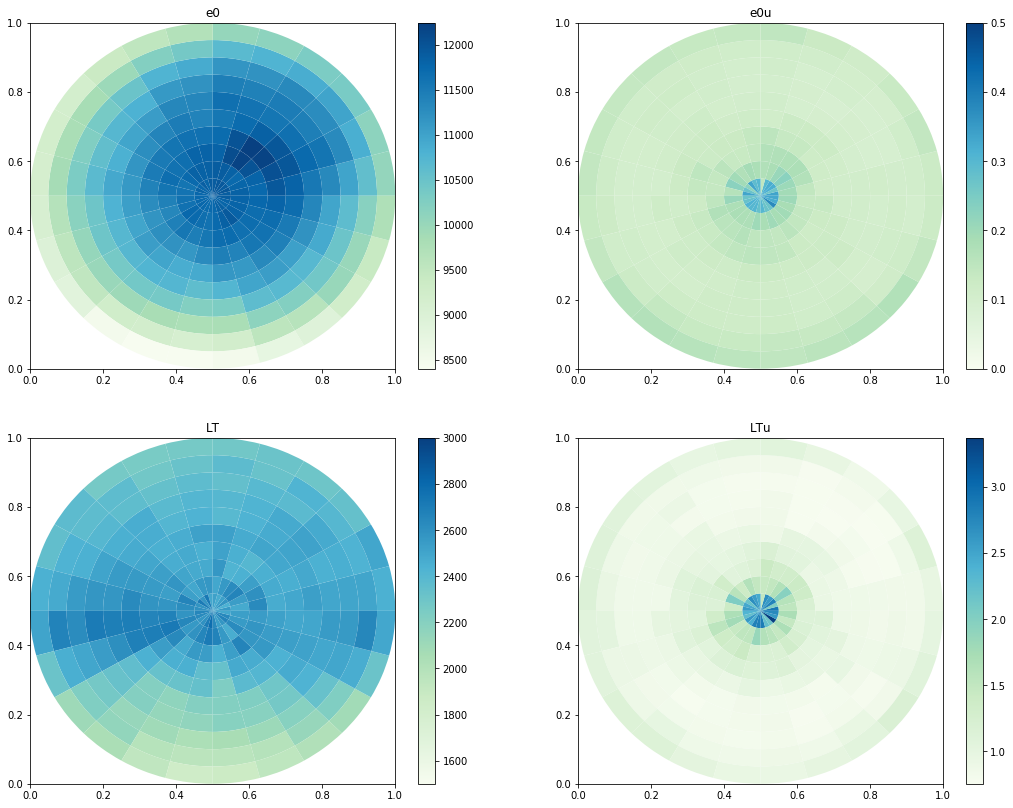

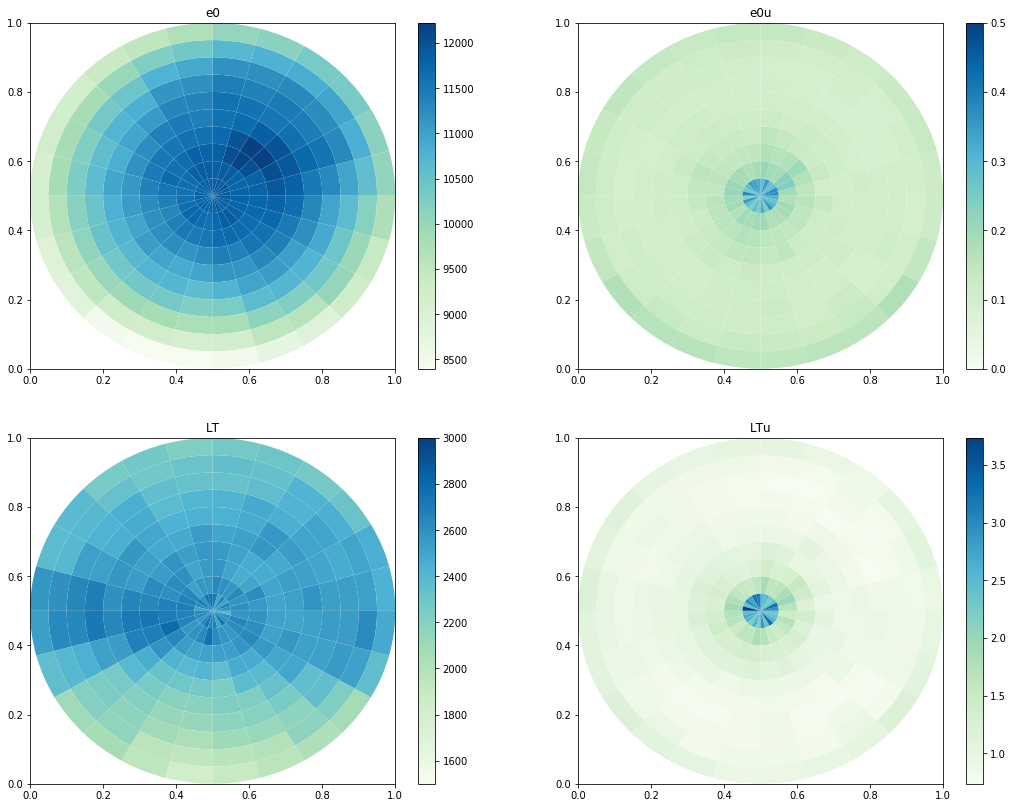

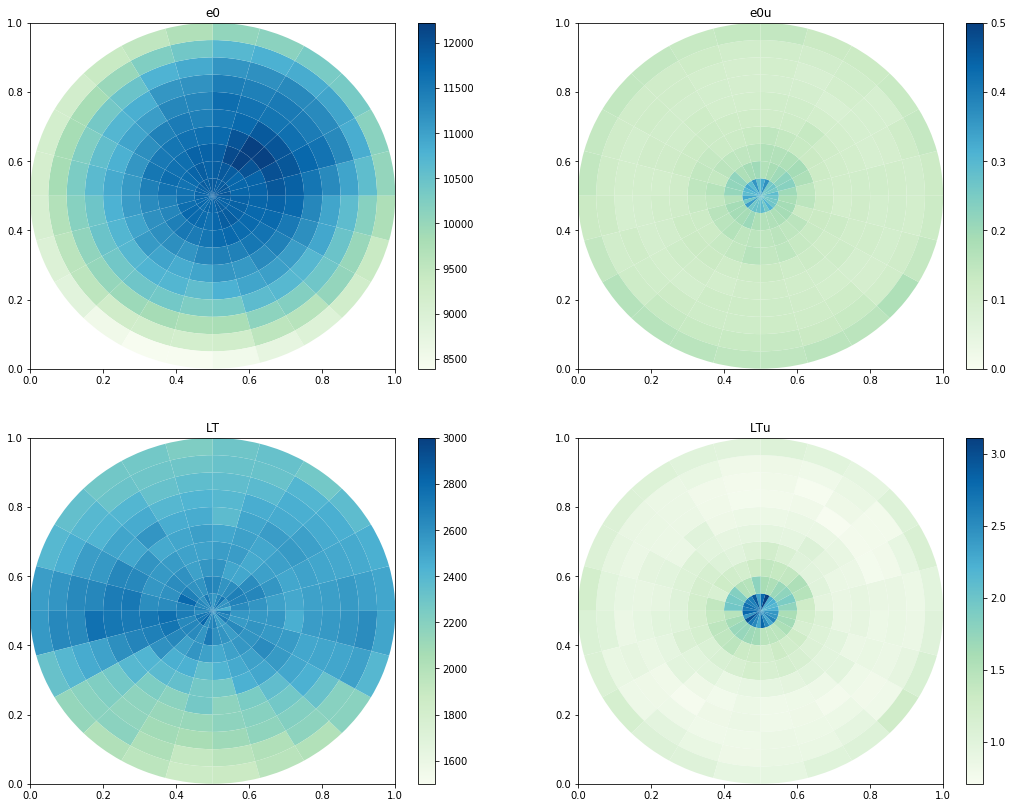

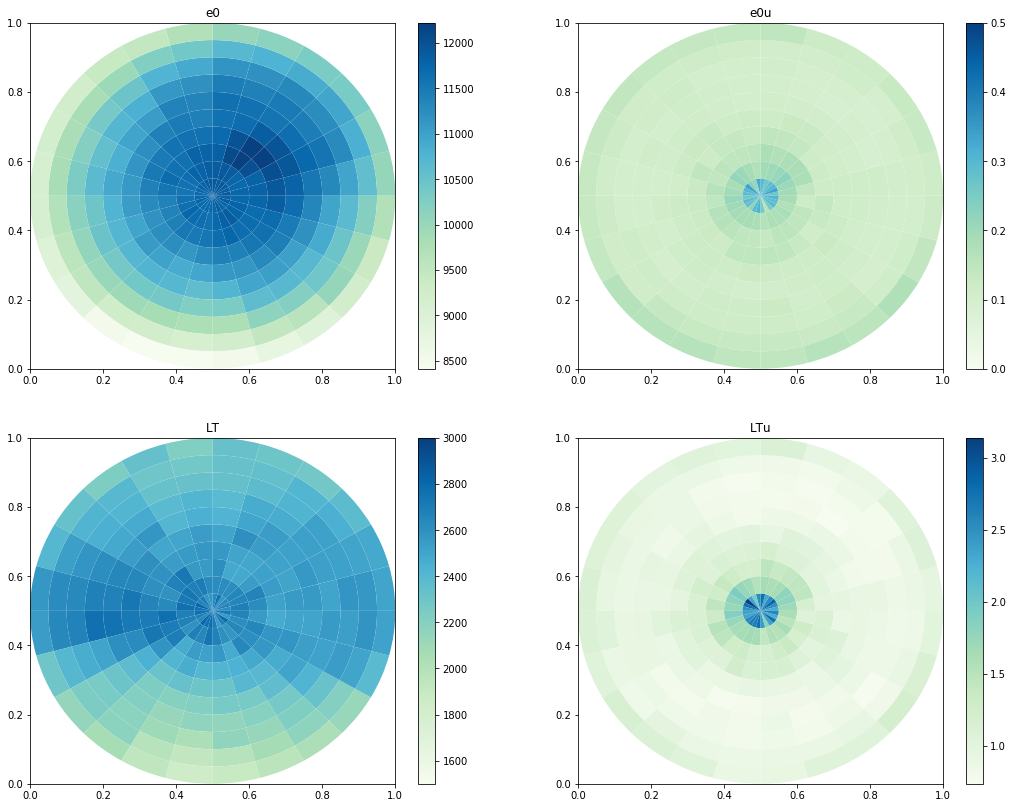

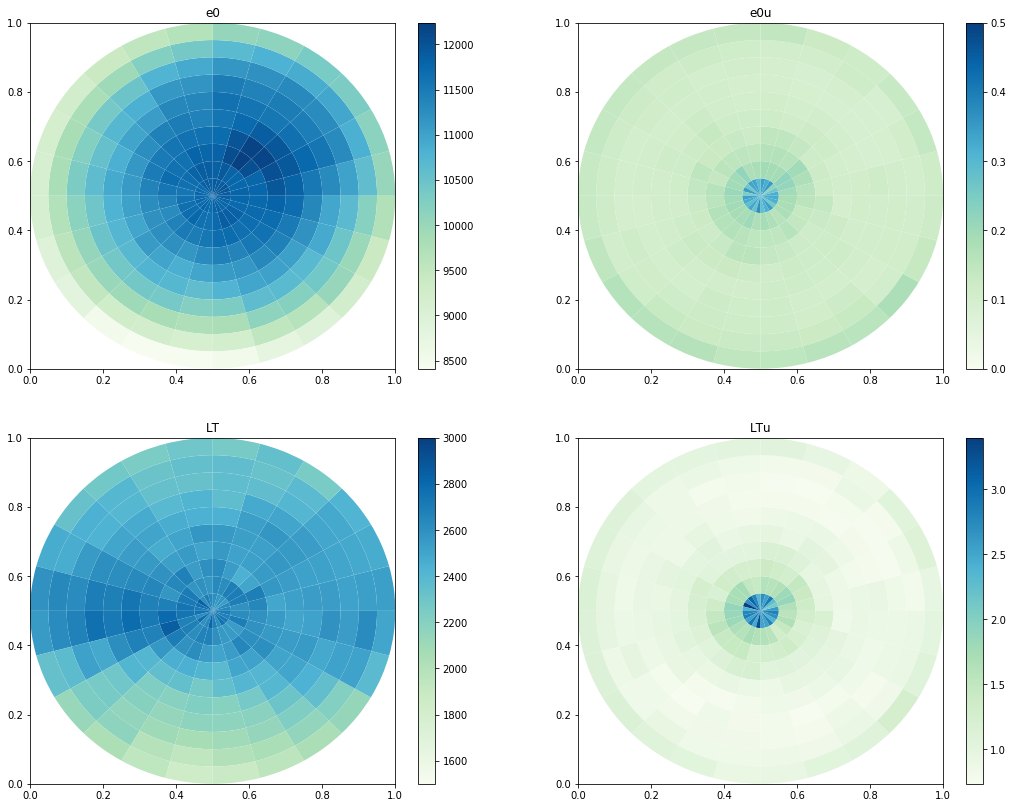

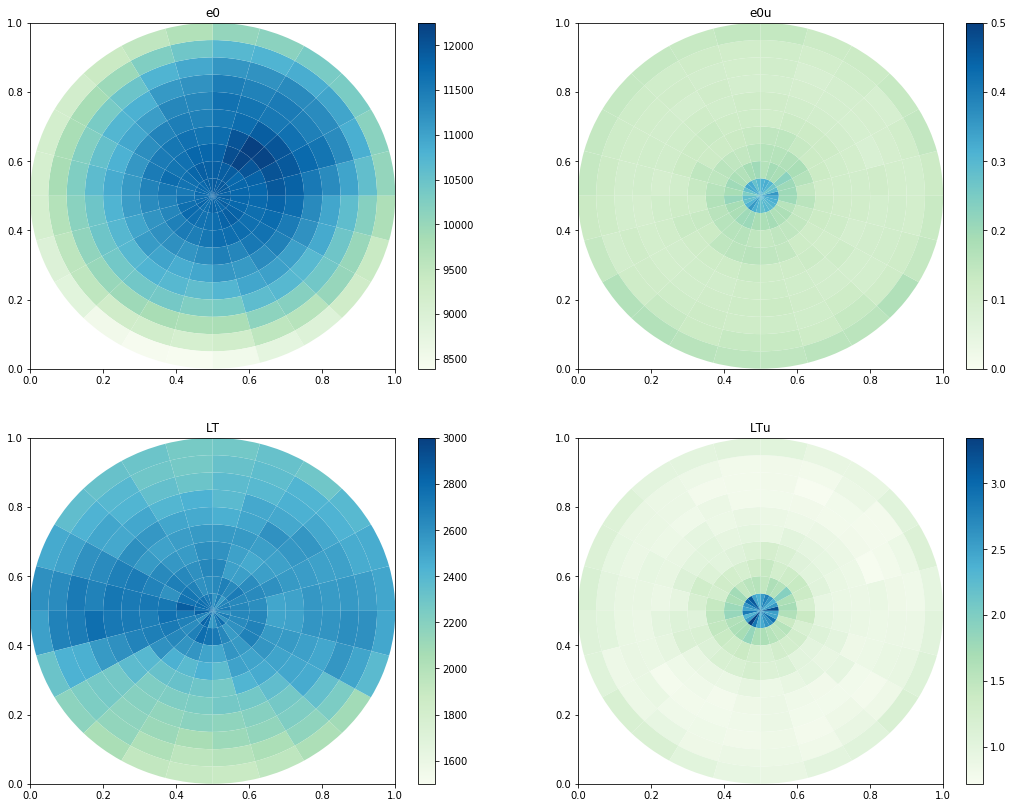

In [146]:
aMaps = []
draw = True
for i, _ in enumerate(ts):
    am = amap_from_tsmap(tsm, 
                         ts = i, 
                         range_e     = (5000, 13000),
                         range_chi2  = (0,3),
                         range_lt    = (1700, 3700))
    asm = relative_errors(am)
    aMaps.append(am)
    if draw:
        draw_maps(W, asm,  
                  e0lims  = None,
                  ltlims  = (1500, 3000),
                  eulims  = (0, 0.5),
                  lulims  = None,
                  cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
                  alpha   = 1.0,  
                  figsize=(18,14))

#### To write the complete time-series of maps
```
write_maps_ts(aMaps : Iterable[ASectorMap], ts: np.array, filename : str)
```

In [159]:
write_maps_ts(aMaps, ts, filename=fn.map_file_name_ts)